## Cartpole

* Environment: The CartPole is a game where the agent moves a cart left or right to keep a pole balanced.
* Agent: The Q-table stores the "value" of each action in each state, helping the agent decide what to do.
* Actions: Move left (0) or right (1).
* Rewards: The agent gets +1 for each step the pole stays balanced.
* Learning: The agent explores randomly at first (epsilon) and gradually learns which actions are best by updating the Q-table.
* Visualization: The plot shows how rewards improve over time, and the animation shows the trained agent balancing the pole.



In [1]:
# Import necessary libraries
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Initialize the CartPole environment
env = gym.make("CartPole-v1")
action_space = env.action_space.n  # Number of actions (left or right)
state_space_bins = [20, 20, 20, 20]  # Discretize continuous state space

In [3]:
# Create bins for discretizing the continuous state space
def create_bins():
    bins = []
    # Cart position, cart velocity, pole angle, pole angular velocity
    bounds = [env.observation_space.low, env.observation_space.high]
    bins.append(np.linspace(bounds[0][0], bounds[1][0], state_space_bins[0]))
    bins.append(np.linspace(bounds[0][1], bounds[1][1], state_space_bins[1]))
    bins.append(np.linspace(bounds[0][2], bounds[1][2], state_space_bins[2]))
    bins.append(np.linspace(bounds[0][3], bounds[1][3], state_space_bins[3]))
    return bins

In [4]:

# Discretize state
def discretize_state(state, bins):
    discretized = []
    for i in range(len(state)):
        discretized.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(discretized)


In [5]:
# Initialize Q-table
bins = create_bins()
q_table = np.zeros(state_space_bins + [action_space])


/usr/local/lib/python3.11/dist-packages/numpy/_core/function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/_core/function_base.py:178: RuntimeWarning: invalid value encountered in add
  y += start


In [6]:
# Q-Learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate
episodes = 1000
rewards = []

In [7]:

# Training loop
for episode in range(episodes):
    state, _ = env.reset()
    state = discretize_state(state, bins)
    total_reward = 0
    done = False

    while not done:
        # Choose action (explore or exploit)
        if np.random.random() < epsilon:
            action = env.action_space.sample()  # Random action
        else:
            action = np.argmax(q_table[state])  # Best action

        # Take action
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state, bins)

        # Update Q-table
        q_table[state][action] += alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
        )

        state = next_state
        total_reward += reward

    rewards.append(total_reward)

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes}, Average Reward: {np.mean(rewards[-100:])}")

Episode 100/1000, Average Reward: 9.89
Episode 200/1000, Average Reward: 10.02
Episode 300/1000, Average Reward: 15.72
Episode 400/1000, Average Reward: 20.01
Episode 500/1000, Average Reward: 20.38
Episode 600/1000, Average Reward: 20.81
Episode 700/1000, Average Reward: 18.55
Episode 800/1000, Average Reward: 25.08
Episode 900/1000, Average Reward: 24.15
Episode 1000/1000, Average Reward: 19.63


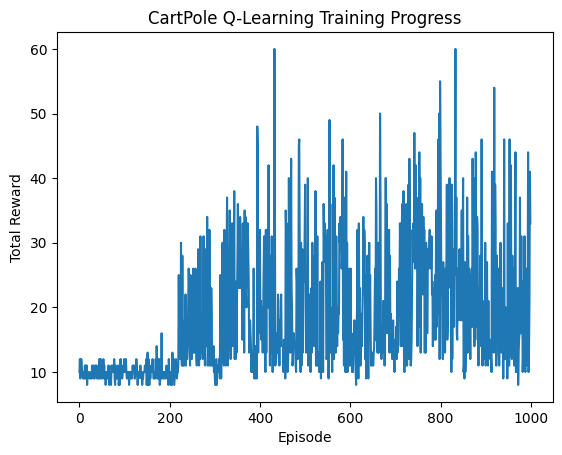

In [8]:
# Plot training progress
plt.plot(range(episodes), rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("CartPole Q-Learning Training Progress")
plt.show()

In [9]:

# Test the trained agent
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
state = discretize_state(state, bins)
done = False
frames = []
while not done:
    action = np.argmax(q_table[state])
    state, reward, done, _, _ = env.step(action)
    state = discretize_state(state, bins)
    frames.append(env.render())

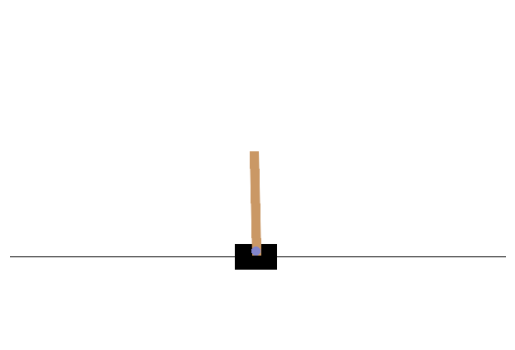

In [10]:
# Note: To visualize the animation in Colab, use the following
from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt

fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())

In [11]:
# Close the environment
env.close()

### Frozen Lake

In [12]:
# Import libraries
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [28]:
# Initialize Frozen Lake environment with rgb_array rendering
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
env = env.unwrapped  # Unwrap to access transition dynamics
n_states = env.observation_space.n
n_actions = env.action_space.n

In [29]:

# Initialize policy and value function
policy = np.zeros(n_states, dtype=int)
value_function = np.zeros(n_states)

In [30]:
# Policy iteration parameters
gamma = 0.99  # Discount factor
theta = 1e-8  # Convergence threshold

In [31]:
def policy_evaluation(policy, env, gamma, theta):
    value_function = np.zeros(n_states)
    while True:
        delta = 0
        for state in range(n_states):
            v = value_function[state]
            action = policy[state]
            # Access transition dynamics from env.P
            transitions = env.P[state][action]  # List of (prob, next_state, reward, done)
            value = 0
            for prob, next_state, reward, done in transitions:
                value += prob * (reward + gamma * value_function[next_state] * (1 - done))
            value_function[state] = value
            delta = max(delta, abs(v - value_function[state]))
        if delta < theta:
            break
    return value_function

In [32]:
def policy_improvement(value_function, env, gamma):
    policy = np.zeros(n_states, dtype=int)
    for state in range(n_states):
        action_values = np.zeros(n_actions)
        for action in range(n_actions):
            transitions = env.P[state][action]
            for prob, next_state, reward, done in transitions:
                action_values[action] += prob * (reward + gamma * value_function[next_state] * (1 - done))
        policy[state] = np.argmax(action_values)
    return policy

In [33]:
# Policy iteration loop
for iteration in range(100):
    old_policy = policy.copy()
    value_function = policy_evaluation(policy, env, gamma, theta)
    policy = policy_improvement(value_function, env, gamma)
    if np.array_equal(old_policy, policy):
        print(f"Converged after {iteration + 1} iterations")
        break

Converged after 7 iterations


In [34]:
# Test the policy and collect frames
state, _ = env.reset()
done = False
steps = 0
frames = []

# Ensure the environment is reset with proper rendering
env.render()  # Initialize rendering
frames.append(env.render())  # Capture initial frame

while not done:
    action = policy[state]
    state, reward, done, _, _ = env.step(action)
    steps += 1
    frame = env.render()
    if frame is not None:  # Ensure frame is valid
        frames.append(frame)

print(f"Reached goal in {steps} steps with reward {reward}")

Reached goal in 6 steps with reward 1.0


In [35]:
# Visualize the policy
policy_grid = np.array(['←', '↓', '→', '↑'])[policy].reshape(4, 4)
print("Learned Policy (←: left, ↓: down, →: right, ↑: up):")
print(policy_grid)

Learned Policy (←: left, ↓: down, →: right, ↑: up):
[['↓' '→' '↓' '←']
 ['↓' '←' '↓' '←']
 ['→' '↓' '↓' '←']
 ['←' '→' '→' '←']]


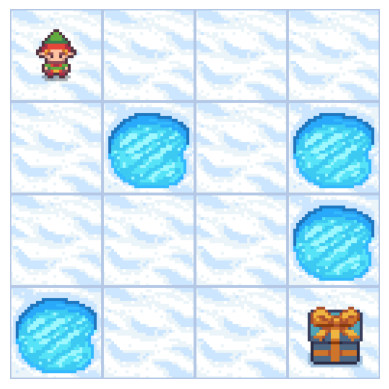

In [36]:
# Visualize the path in Colab
fig = plt.figure()
plt.axis("off")
# Ensure frames are in uint8 format for imshow
frames = [np.array(frame, dtype=np.uint8) for frame in frames if frame is not None]
im = plt.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=200)
HTML(anim.to_jshtml())

In [37]:
# Close the environment
env.close()

## Taxi V3

In [38]:
# Import libraries
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation

In [39]:
# Initialize Taxi environment with rgb_array rendering
env = gym.make("Taxi-v3", render_mode="rgb_array")
n_states = env.observation_space.n  # 500 states (5x5 grid, 5 passenger locations, 4 destinations)
n_actions = env.action_space.n     # 6 actions (move south, north, east, west, pickup, dropoff)

In [40]:

# Initialize Q-table
np.random.seed(42)
q_table = np.zeros((n_states, n_actions))

In [41]:
# SARSA parameters
alpha = 0.1   # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1 # Exploration rate
episodes = 2000
rewards = []


In [42]:
# SARSA training loop
for episode in range(episodes):
    state, _ = env.reset()
    action = np.random.choice(n_actions) if np.random.random() < epsilon else np.argmax(q_table[state])
    total_reward = 0
    done = False

    while not done:
        # Take action
        next_state, reward, done, _, _ = env.step(action)
        # Choose next action (on-policy)
        next_action = np.random.choice(n_actions) if np.random.random() < epsilon else np.argmax(q_table[next_state])
        # Update Q-table
        q_table[state, action] += alpha * (
            reward + gamma * q_table[next_state, next_action] * (1 - done) - q_table[state, action]
        )
        state = next_state
        action = next_action
        total_reward += reward

    rewards.append(total_reward)

    # Print progress every 200 episodes
    if (episode + 1) % 200 == 0:
        print(f"Episode {episode + 1}/{episodes}, Average Reward: {np.mean(rewards[-200:]):.2f}")


Episode 200/2000, Average Reward: -432.63
Episode 400/2000, Average Reward: -106.01
Episode 600/2000, Average Reward: -54.82
Episode 800/2000, Average Reward: -23.96
Episode 1000/2000, Average Reward: -9.78
Episode 1200/2000, Average Reward: -6.29
Episode 1400/2000, Average Reward: -3.97
Episode 1600/2000, Average Reward: -1.84
Episode 1800/2000, Average Reward: -2.10
Episode 2000/2000, Average Reward: 1.14


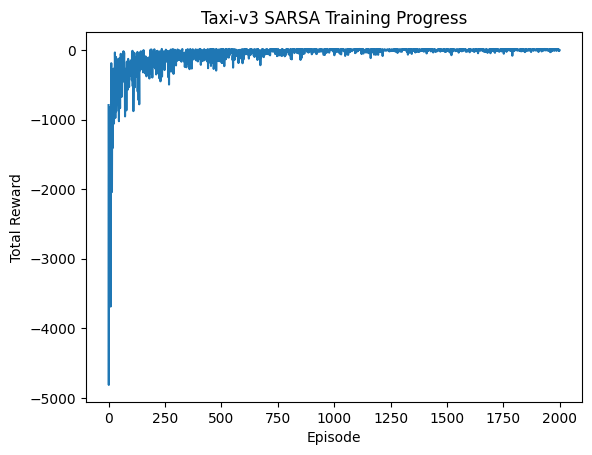

In [43]:
# Plot training progress
plt.plot(range(episodes), rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Taxi-v3 SARSA Training Progress")
plt.show()

In [44]:

# Test the trained agent
state, _ = env.reset()
done = False
steps = 0
frames = []
frames.append(np.array(env.render(), dtype=np.uint8))  # Initial frame

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, _, _ = env.step(action)
    steps += 1
    frame = env.render()
    if frame is not None:
        frames.append(np.array(frame, dtype=np.uint8))
print(f"Test episode completed in {steps} steps")


Test episode completed in 14 steps


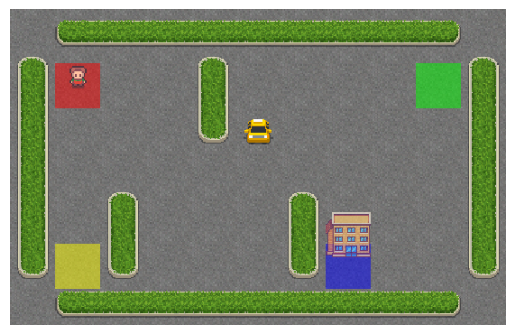

In [45]:

# Visualize the test episode in Colab
fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=200)
HTML(anim.to_jshtml())


In [46]:
# Close the environment
env.close()